In [1]:
from databaker.framework import *
inputfile = "gdpq3m2reftables_tcm77-425649.xls"
previewfile = "preview.html"

tab = loadxlstabs(inputfile, "A1 AGGREGATES")[0]


Loading gdpq3m2reftables_tcm77-425649.xls which has size 2115072 bytes
Table names: ['A1 AGGREGATES']


In [2]:
1
# get dates column, and dates column headings
# separate those upper columns, and codes
# get the dates into different pandas periods cases
# relate the percentage change one from other

1

In [3]:
# use these to extract the list of entries (header names) and compare them
# will result in quick/useful plot-up of the error

def valueslist(bag):
    return [cell.value  for cell in sorted(bag.unordered_cells, key=lambda cell: (cell.y, cell.x))]

def checkvalues(bag, vlist):
    scells = sorted(bag.unordered_cells, key=lambda cell: (cell.y, cell.x))
    assert len(scells) == len(vlist), "checkvalues list length doesn't match"
    for cell, v in zip(scells, vlist):
        assert cell.value == v, ("checkvalues mismatch", (cell.x, cell.y), cell.value, v)

# need a rectangle creation thing that selects the blanks in between 
# a row or columns of cells, which is a more robust thing to compare against


In [4]:
conversionsegments = [ ]

columnA = tab.excel_ref('A2').expand(DOWN).is_not_blank()
datescolumn = columnA.is_date()
datessubsecs = columnA - datescolumn

headeranchor = tab.filter("YBEU")
obspane = headeranchor.expand(RIGHT).expand(DOWN).is_not_blank()
obs = datescolumn.expand(RIGHT) & obspane
obsletterheadings = obspane - obs
wordheadings = headeranchor.shift(UP).expand(RIGHT).is_not_blank()
wordsectionheadings = wordheadings.shift(UP).is_not_blank()

# NB these are the validifacation testing checks, copied in here by printing valueslist(wordheadings) first
checkvalues(wordheadings, ['Gross domestic product at market prices', 'Gross value added at basic prices', 
                           'Gross domestic product at market prices', 'Gross value added at basic prices', 
                           'Market sector gross value added', 'Gross domestic expenditure', 
                           'Gross domestic product at market prices', 'Gross value added at basic prices'])

checkvalues(wordsectionheadings, ['Value indices at current prices', 'Chained  volume indices', 'Implied deflators 2'])

# we need to insert in the blank cells, which we then overrride!
h1c2 = wordsectionheadings.by_index(2)
h1c3 = wordsectionheadings.by_index(3)
wordsectionheadingsP = wordsectionheadings | h1c2.shift(LEFT) | h1c3.shift(LEFT)
h1 = HDim(wordsectionheadingsP, "headingshortword", CLOSEST, LEFT)
h1.cellvalueoverride[h1c2.shift(LEFT)._cell] = h1c2.value
h1.cellvalueoverride[h1c3.shift(LEFT)._cell] = h1c3.value

dimensions = [ 
    HDim(datescolumn, TIME, DIRECTLY, LEFT),
    HDim(datessubsecs, "datesubsection", CLOSEST, UP), 
    HDim(obsletterheadings, "headingletter", DIRECTLY, UP), 
    HDim(wordheadings, "headingword", DIRECTLY, UP),
    h1 
]

#savepreviewhtml([datescolumn, datessubsecs, obsletterheadings, obs, wordheadings, wordsectionheadings], previewfile)
c1 = ConversionSegment(tab, dimensions, obs.is_number())
savepreviewhtml(c1, previewfile)
        
        
# https://sensiblecodeio.github.io/quickcode-ons-docs/lang/function_reference.html

tablepart 'A1 AGGREGATES' written #injblock1001
javascript calculated


In [5]:
df = topandas(c1)


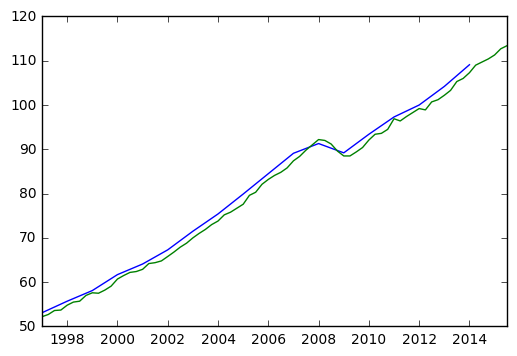

In [6]:
%matplotlib inline
from matplotlib import pyplot as plt


ybeuY = df[(df.headingletter == "YBEU") & (df.TIMEUNIT == "Year")]
ybeuQ = df[(df.headingletter == "YBEU") & (df.TIMEUNIT == "Quarter")]
len(ybeuY), len(ybeuQ)
plt.plot(ybeuY.TIME, ybeuY.OBS)
plt.plot(ybeuQ.TIME, ybeuQ.OBS)

#df.groupby([df['Source'],pd.TimeGrouper(freq='Min')])


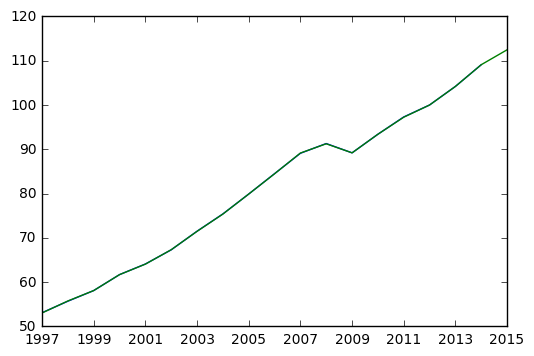

In [8]:
# work out the series of aggregations to get the two to match
ybeuQ = ybeuQ.copy()

# set the year for each quarter
ybeuQ["YEAR"] = ybeuQ.apply(lambda row: pd.to_datetime(str(row.TIME.year)), axis=1)

# group by these years and average them
ybeuQY = ybeuQ.groupby(ybeuQ.YEAR)["YEAR", "OBS"].mean()

# matches perfectly
plt.plot(ybeuY.TIME, ybeuY.OBS)
plt.plot(ybeuQY.index, ybeuQY.OBS)


In [114]:
# this date stuff is not necessarily perfect, but it's best for now.  I should also 
# learn more about how to do stacked pandas indexes, which is designed for this
# Finally, some understanding of this GDP stats would be useful

# Next trick is to prove the values of the "Percentage change, latest year on previous year" segments of data

# then see if this can be extended cleanly to the other tables to find reduncancies in the data

# also need a summary preview of the excel tables inline where we trim out the repeat sections and can just 
# see the structure of headings, etc

# Then 


(0       53.1
 8       55.7
 16      58.1
 24      61.7
 32      64.1
 40      67.3
 48      71.5
 56      75.4
 64      79.9
 72      84.5
 80      89.1
 88      91.3
 96      89.2
 104     93.4
 112     97.3
 120    100.0
 128    104.2
 136    109.1
 Name: OBS, dtype: float64, YEAR
 1997-01-01     53.050000
 1998-01-01     55.750000
 1999-01-01     58.100000
 2000-01-01     61.700000
 2001-01-01     64.075000
 2002-01-01     67.325000
 2003-01-01     71.475000
 2004-01-01     75.375000
 2005-01-01     79.900000
 2006-01-01     84.475000
 2007-01-01     89.150000
 2008-01-01     91.250000
 2009-01-01     89.200000
 2010-01-01     93.400000
 2011-01-01     97.250000
 2012-01-01    100.000000
 2013-01-01    104.200000
 2014-01-01    109.100000
 2015-01-01    112.466667
 Name: OBS, dtype: float64)

In [8]:
"""
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "A1 AGGREGATES" None Y
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "A1 AGGREGATES" None Q
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "A2 AGGREGATES" None Y
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "A2 AGGREGATES" None Q
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "B1 CVM OUTPUT" "B2 CVM OUTPUT" Y
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "B1 CVM OUTPUT" "B2 CVM OUTPUT" Q
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "C1 EXPENDITURE" "C2 EXPENDITURE" Y
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "C1 EXPENDITURE" "C2 EXPENDITURE" Q
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "D INCOME" None Y
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "D INCOME" None Q
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "H1 TRADE" "H2 TRADE" Y
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "H1 TRADE" "H2 TRADE" Q
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "L GVAbp" None Y
bake --preview recipe.py gdpq3m2reftables_tcm77-425649.xls "L GVAbp" None Q
"""
DOWN

(0, 1)